This is step by step procedure to get the 80.51% accuracy in the online competition. The highest accuracy is 82.85 as of now on 05/26/2018.

In this notebook, for hit and trial, I have also used Boruta library to select the best features. And surprisingly it gave the best result 80.51. 

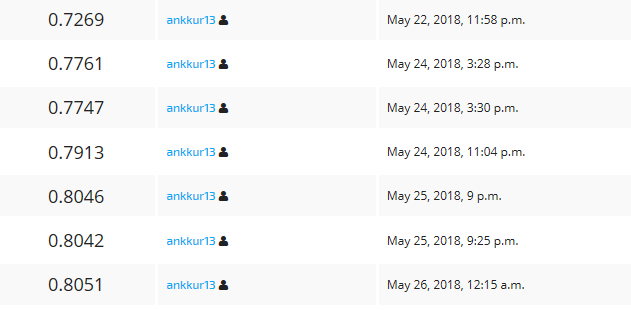

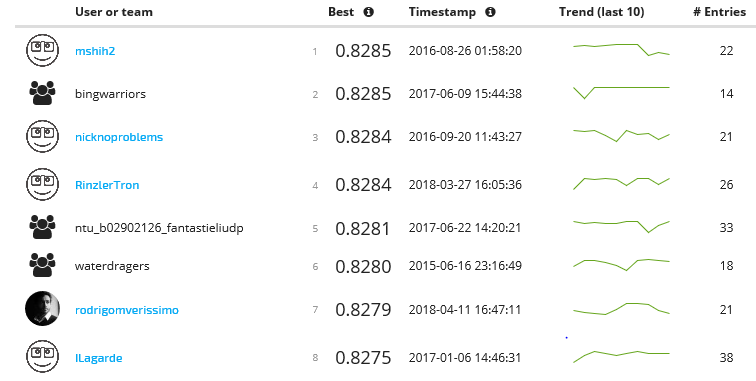

In [703]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

In [704]:
train_values = pd.read_csv("Train_values.csv")
train_labels=pd.read_csv("Train_labels.csv")

In [705]:
train=train_values.merge(train_labels,on='id',how='inner')

In [706]:
test=pd.read_csv('Test_values.csv')
test_copy=test.copy()

In [707]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [708]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [709]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

In [710]:
#convert status group label into numerical data
val_status_group={'functional':2, 'functional needs repair':1,
                   'non functional':0}
train['status_group_vals']=train.status_group.replace(val_status_group)

In [711]:
#Lets focus on each field one by one
#funder
train['funder'].value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
District Council           843
Dhv                        829
Private Individual         826
Dwsp                       811
0                          777
Norad                      765
Germany Republi            610
Tcrs                       602
Ministry Of Water          590
Water                      583
Dwe                        484
Netherlands                470
Hifab                      450
Adb                        448
Lga                        442
Amref                      425
Fini Water                 393
Oxfam                      359
Wateraid                   333
Rc Church                  321
Isf                        316
                          ... 
Agt Church                   1
Arabi   

In [712]:
#Lets divide funder column into 5 categories, top 5 will be remained as it is and after that they will be categorised into other
def funder_cleaning(train):
    if train['funder']=='Government Of Tanzania':
        return 'government'
    elif train['funder']=='Danida':
        return 'danida'
    elif train['funder']=='Hesawa':
        return 'hesawa'
    elif train['funder']=='Rwssp':
        return 'rwssp'
    elif train['funder']=='World Bank':
        return 'world_bank'    
    else:
        return 'other'
    
train['funder']= train.apply(lambda row: funder_cleaning(row), axis=1)
test['funder']= test.apply(lambda row: funder_cleaning(row), axis=1)

In [713]:
#Lets focus on each field one by one
#installer
train['installer'].value_counts()

DWE                           17402
Government                     1825
RWE                            1206
Commu                          1060
DANIDA                         1050
KKKT                            898
Hesawa                          840
0                               777
TCRS                            707
Central government              622
CES                             610
Community                       553
DANID                           552
District Council                551
HESAWA                          539
LGA                             408
World vision                    408
WEDECO                          397
TASAF                           396
District council                392
Gover                           383
AMREF                           329
TWESA                           316
WU                              301
Dmdd                            287
ACRA                            278
World Vision                    270
SEMA                        

In [714]:
#Lets divide installer column into 5 categories, top 5 will be remained as it is and after that they will be categorised into other
def installer_cleaning(train):
    if train['installer']=='DWE':
        return 'dwe'
    elif train['installer']=='Government':
        return 'government'
    elif train['installer']=='RWE':
        return 'rwe'
    elif train['installer']=='Commu':
        return 'commu'
    elif train['installer']=='DANIDA':
        return 'danida'    
    else:
        return 'other'
    
train['installer']= train.apply(lambda row: installer_cleaning(row), axis=1)
test['installer']= test.apply(lambda row: installer_cleaning(row), axis=1)

In [715]:
#EDA
# Checking Null Values on training data
train.apply(lambda x: sum(x.isnull()), axis=0)

id                           0
amount_tsh                   0
date_recorded                0
funder                       0
gps_height                   0
installer                    0
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [716]:
piv_table  = pd.pivot_table(train,index=['funder','status_group'],
                           values='status_group_vals', aggfunc='count')
piv_table

status_group_vals
funder     status_group                              
danida     functional                            1713
           functional needs repair                159
           non functional                        1242
government functional                            3720
           functional needs repair                701
           non functional                        4663
hesawa     functional                             936
           functional needs repair                232
           non functional                        1034
other      functional                           24540
           functional needs repair               3019
           non functional                       14718
rwssp      functional                             805
           functional needs repair                109
           non functional                         460
world_bank functional                             545
           functional needs repair                 97
           non functional                         707

In [717]:
#Like funder and installer it is hard to categorize them into 5 or 6 subvillages because values are not dominating 
#and 19287 unique values are there and the top values are not dominating though

train['subvillage'].value_counts()

#better to drop this column

Madukani                  508
Shuleni                   506
Majengo                   502
Kati                      373
Mtakuja                   262
Sokoni                    232
M                         187
Muungano                  172
Mbuyuni                   164
Mlimani                   152
Songambele                147
Msikitini                 134
Miembeni                  134
1                         132
Kibaoni                   114
Kanisani                  111
I                         109
Mapinduzi                 109
Mjini                     108
Mjimwema                  108
Mkwajuni                  104
Mwenge                    102
Mabatini                   98
Azimio                     98
Mission                    95
Mbugani                    95
Bwawani                    91
Bondeni                    90
Chang'Ombe                 88
Zahanati                   86
                         ... 
Fumagila Magharib           1
Maili Kumi                  1
Bukuba A  

In [718]:
train=train.drop(['subvillage'],axis=1)
test=test.drop(['subvillage'],axis=1)

In [719]:
#public_meeting
train['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [720]:
#Since most of the values are True, as of now lets insert True for the missing values. Scope to alter the values in future
train.public_meeting = train.public_meeting.fillna('Unknown')
test.public_meeting = test.public_meeting.fillna('Unknown')

In [721]:
#Scheme Management
train['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [722]:
# Create a function to reduce the amount of dummy columns needed whilst maintaining the 
# information contained in the column.

def scheme_wrangler(row):
    '''Keep top 5 values and set the rest to 'other'. '''
    if row['scheme_management']=='VWC':
        return 'vwc'
    elif row['scheme_management']=='WUG':
        return 'wug'
    elif row['scheme_management']=='Water authority':
        return 'wtr_auth'
    elif row['scheme_management']=='WUA':
        return 'wua'
    elif row['scheme_management']=='Water Board':
        return 'wtr_brd'
    else:
        return 'other'

train['scheme_management'] = train.apply(lambda row: scheme_wrangler(row), axis=1)
test['scheme_management'] = test.apply(lambda row: scheme_wrangler(row), axis=1)

In [723]:
#Scheme name
train['scheme_name'].value_counts()

K                                        682
None                                     644
Borehole                                 546
Chalinze wate                            405
M                                        400
DANIDA                                   379
Government                               320
Ngana water supplied scheme              270
wanging'ombe water supply s              261
wanging'ombe supply scheme               234
I                                        229
Bagamoyo wate                            229
Uroki-Bomang'ombe water sup              209
N                                        204
Kirua kahe gravity water supply trust    193
Machumba estate pipe line                185
Makwale water supplied sche              166
Kijiji                                   161
S                                        154
mtwango water supply scheme              152
Handeni Trunk Main(H                     152
Losaa-Kia water supply                   152
Mkongoro T

In [724]:
len(train.scheme_name.unique())

# Lots of factors and the top 5 or so only represent a fraction of the total values. Probably 
# safe to drop this column.

train = train.drop('scheme_name', axis=1)
test = test.drop('scheme_name', axis=1)

In [725]:
#permit
train['permit'].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [726]:
# We only have two values here: true and false. This one can stay but we'll have to replace 
# the unknown data with a string value.

train.permit = train.permit.fillna('Unknown')
test.permit = test.permit.fillna('Unknown')


In [727]:
#EDA
# Checking Null Values on test data
train.apply(lambda x: sum(x.isnull()), axis=0)

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
w

In [728]:
#From the above data, we can say the data is clean for both the training and testing.

In [729]:
#checking the correlation values of training datatest.corr()
train.corr()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group_vals
id,1.000000,-0.005321,-0.004692,-0.001348,0.001718,-0.002629,-0.003028,-0.003044,-0.002813,-0.002082,-0.004049
amount_tsh,-0.005321,1.000000,0.076650,0.022134,-0.052670,0.002944,-0.026813,-0.023599,0.016288,0.067915,0.053702
gps_height,-0.004692,0.076650,1.000000,0.149155,-0.035751,0.007237,-0.183521,-0.171233,0.135003,0.658727,0.114029
longitude,-0.001348,0.022134,0.149155,1.000000,-0.425802,0.023873,0.034197,0.151398,0.086590,0.396732,-0.004366
latitude,0.001718,-0.052670,-0.035751,-0.425802,1.000000,0.006837,-0.221018,-0.201020,-0.022152,-0.245278,0.014547
num_private,-0.002629,0.002944,0.007237,0.023873,0.006837,1.000000,-0.020377,-0.004478,0.003818,0.026056,0.005021
region_code,-0.003028,-0.026813,-0.183521,0.034197,-0.221018,-0.020377,1.000000,0.678602,0.094088,0.031724,-0.108640
district_code,-0.003044,-0.023599,-0.171233,0.151398,-0.201020,-0.004478,0.678602,1.000000,0.061831,0.048315,-0.065687
population,-0.002813,0.016288,0.135003,0.086590,-0.022152,0.003818,0.094088,0.061831,1.000000,0.260910,0.017759
construction_year,-0.002082,0.067915,0.658727,0.396732,-0.245278,0.026056,0.031724,0.048315,0.260910,1.000000,0.043342


In [730]:
#checking the correlation values of testing datatest.corr()
test.corr()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
id,1.000000,-0.016012,0.002711,-0.003331,0.009632,-0.016040,0.002601,-0.000655,-0.016068,-0.004591
amount_tsh,-0.016012,1.000000,0.096230,0.027709,-0.072210,0.022978,-0.028887,-0.027391,0.028657,0.086236
gps_height,0.002711,0.096230,1.000000,0.148722,-0.045028,0.013331,-0.177832,-0.169586,0.131994,0.656781
longitude,-0.003331,0.027709,0.148722,1.000000,-0.430001,0.030979,0.024354,0.148962,0.090862,0.397361
latitude,0.009632,-0.072210,-0.045028,-0.430001,1.000000,0.002048,-0.203080,-0.196176,-0.024123,-0.256610
num_private,-0.016040,0.022978,0.013331,0.030979,0.002048,1.000000,-0.028188,-0.010341,0.001517,0.036118
region_code,0.002601,-0.028887,-0.177832,0.024354,-0.203080,-0.028188,1.000000,0.687910,0.097118,0.029993
district_code,-0.000655,-0.027391,-0.169586,0.148962,-0.196176,-0.010341,0.687910,1.000000,0.066425,0.046214
population,-0.016068,0.028657,0.131994,0.090862,-0.024123,0.001517,0.097118,0.066425,1.000000,0.272421
construction_year,-0.004591,0.086236,0.656781,0.397361,-0.256610,0.036118,0.029993,0.046214,0.272421,1.000000


As we can see, the values are not correlated with each other. That is good for the model

In [731]:
train['recorded_by'].value_counts()
#we can drop this column because all the values in this column are same. There is no point to go forward with this column.

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [732]:
train=train.drop(['recorded_by'],axis=1)
test=test.drop(['recorded_by'],axis=1)

In [733]:
train.apply(lambda x: len(x.unique()))

id                       59400
amount_tsh                  98
date_recorded              356
funder                       6
gps_height                2428
installer                    6
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               3
scheme_management            6
permit                       3
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source  

In [734]:
train['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [735]:
train['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [736]:
# waterpoint_type and waterpoint_type_group both are almost similar, communal standpipe and comunal standpipe multiple are merged 
# together in waterpoint_type_group
# we can drop one of them

train=train.drop(['waterpoint_type'],axis=1)
test=test.drop(['waterpoint_type'],axis=1)

In [737]:
train['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [738]:
train['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [739]:
train['source_class'].value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [740]:
#from the above script, we can say the source and source_type are same because in source_type some values are merged together. 
# we can drop one of the column.

train=train.drop(['source'],axis=1)
test=test.drop(['source'],axis=1)

In [741]:
train['quantity'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [742]:
train['quantity_group'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [743]:
#from the above script, we can say the quantity and quantity_group both are same.
# we can drop one of the column.

train=train.drop(['quantity'],axis=1)
test=test.drop(['quantity'],axis=1)

In [744]:
train['water_quality'].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [745]:
train['quality_group'].value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [746]:
#water_quality and quality_group are correlated . lets drop one of the column
train=train.drop(['quality_group'],axis=1)
test=test.drop(['quality_group'],axis=1)

In [747]:
train['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [748]:
train['payment_type'].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [749]:
#from the above script, we can say the payment and payment_type both are same.
# we can drop one of the column.

train=train.drop(['payment'],axis=1)
test=test.drop(['payment'],axis=1)

In [750]:
train['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [751]:
train['management_group'].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [752]:
#from the above script, we can say the management and management_group both are same, some values are merged together in management-group.
# we can drop one of the column.

train=train.drop(['management'],axis=1)
test=test.drop(['management'],axis=1)

In [753]:
train['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [754]:
train['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [755]:
train['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [756]:
#from the above script, we can say the exrtaction_type, extraction_type_group and extraction_type_class are same, some values are merged together.

train=train.drop(['extraction_type'],axis=1)
test=test.drop(['extraction_type'],axis=1)

train=train.drop(['extraction_type_group'],axis=1)
test=test.drop(['extraction_type_group'],axis=1)

In [757]:
# gps_height, longitude, latitude, region_code and district_code are all geographic info which# gps_he 
# is unlikely to add any predictive power to the model given that there are other variables
# containing geographic data. 'num_private' hasn't been given a discription on Driven Data,
# it appears to be superflous. We expect id to not contain any useful information so that gets
# dropped too. wpt_name is also not required, it gives only waterpoint name

train = train.drop(['gps_height', 'longitude', 'latitude', 'region_code', 'district_code',
             'num_private', 'id','wpt_name','lga','region','ward','status_group'], axis=1)

test = test.drop(['gps_height', 'longitude', 'latitude', 'region_code', 'district_code',
             'num_private', 'id','wpt_name','lga','region','ward'], axis=1)

In [758]:
# Turn construction_year into a categorical column containing the following values: '60s', '70s',
# '80s', '90s, '00s', '10s', 'unknown'.

def construction_wrangler(row):
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60s'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70s'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80s'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90s'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00s'
    elif row['construction_year'] >= 2010:
        return '10s'
    else:
        return 'unknown'
    
train['construction_year'] = train.apply(lambda row: construction_wrangler(row), axis=1)
test['construction_year'] = test.apply(lambda row: construction_wrangler(row), axis=1)

In [759]:
train['population'].value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
300      1476
100      1146
50       1139
500      1009
350       986
120       916
400       775
60        706
30        626
40        552
80        533
450       499
20        462
600       438
230       388
75        289
1000      278
800       269
90        265
130       264
25        255
320       249
35        245
360       222
140       215
        ...  
8848        1
628         1
4520        1
468         1
693         1
725         1
789         1
821         1
5300        1
3127        1
2345        1
3031        1
886         1
392         1
424         1
2807        1
726         1
694         1
2569        1
4788        1
662         1
4660        1
406         1
1032        1
1160        1
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

In [760]:
test.date_recorded = pd.datetime(2013, 12, 3) - pd.to_datetime(test.date_recorded)
test.columns = ['days_since_recorded' if x=='date_recorded' else x for x in test.columns]
test.days_since_recorded = test.days_since_recorded.astype('timedelta64[D]').astype(int)

train.date_recorded = pd.datetime(2013, 12, 3) - pd.to_datetime(train.date_recorded)
train.columns = ['days_since_recorded' if x=='date_recorded' else x for x in train.columns]
train.days_since_recorded = train.days_since_recorded.astype('timedelta64[D]').astype(int)

In [761]:
train.apply(lambda x: len(x.unique()))

amount_tsh                 98
days_since_recorded       356
funder                      6
installer                   6
basin                       9
population               1049
public_meeting              3
scheme_management           6
permit                      3
construction_year           7
extraction_type_class       7
management_group            5
payment_type                7
water_quality               8
quantity_group              5
source_type                 7
source_class                3
waterpoint_type_group       6
status_group_vals           3
dtype: int64

In [762]:
test.apply(lambda x: len(x.unique()))

amount_tsh                68
days_since_recorded      331
funder                     6
installer                  6
basin                      9
population               637
public_meeting             3
scheme_management          6
permit                     3
construction_year          7
extraction_type_class      7
management_group           5
payment_type               7
water_quality              8
quantity_group             5
source_type                7
source_class               3
waterpoint_type_group      6
dtype: int64

In [763]:
train.shape

(59400, 19)

In [764]:
test.shape

(14850, 18)

In [765]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import pandas_profiling
from boruta import BorutaPy
from datetime import datetime

In [766]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 19 columns):
amount_tsh               59400 non-null float64
days_since_recorded      59400 non-null int32
funder                   59400 non-null object
installer                59400 non-null object
basin                    59400 non-null object
population               59400 non-null int64
public_meeting           59400 non-null object
scheme_management        59400 non-null object
permit                   59400 non-null object
construction_year        59400 non-null object
extraction_type_class    59400 non-null object
management_group         59400 non-null object
payment_type             59400 non-null object
water_quality            59400 non-null object
quantity_group           59400 non-null object
source_type              59400 non-null object
source_class             59400 non-null object
waterpoint_type_group    59400 non-null object
status_group_vals        59400 non-null int64


In [767]:
# Get dummy columns for the categorical columns and shuffle the data.

dummy_cols = ['funder', 'installer', 'basin', 'public_meeting', 'scheme_management', 'permit',
              'construction_year', 'extraction_type_class','management_group', 'payment_type', 'water_quality',
              'quantity_group', 'source_type', 'source_class','waterpoint_type_group']

train = pd.get_dummies(train, columns = dummy_cols)

train = train.sample(frac=1).reset_index(drop=True)

In [768]:
test = pd.get_dummies(test, columns = dummy_cols)

In [769]:
print('Shape of training data',train.shape)
print('Shape of testing data',test.shape)

Shape of training data (59400, 92)
Shape of testing data (14850, 91)


In [770]:
#profiling report of training data
#pandas_profiling.ProfileReport(train)

In [771]:
#from profiling report, we can drop duplicate rows from the training dataset and also we can see 
#waterpoint_type_group_hand pump is highly correlated with extraction_type_class_handpump. we can drop any one of the column

#train=train.drop_duplicates()

train=train.drop(['waterpoint_type_group_hand pump'],axis=1)
test=test.drop(['waterpoint_type_group_hand pump'],axis=1)

train=train.drop(['source_type_other'],axis=1)
test=test.drop(['source_type_other'],axis=1)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 90 columns):
amount_tsh                                  59400 non-null float64
days_since_recorded                         59400 non-null int32
population                                  59400 non-null int64
status_group_vals                           59400 non-null int64
funder_danida                               59400 non-null uint8
funder_government                           59400 non-null uint8
funder_hesawa                               59400 non-null uint8
funder_other                                59400 non-null uint8
funder_rwssp                                59400 non-null uint8
funder_world_bank                           59400 non-null uint8
installer_commu                             59400 non-null uint8
installer_danida                            59400 non-null uint8
installer_dwe                               59400 non-null uint8
installer_government                        

In [772]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [786]:
# Let's split the train set into train and validation sets. Also remove the target.

target = train.status_group_vals
features = train.drop('status_group_vals', axis=1)

features1=features.copy()

In [778]:
rf = RandomForestClassifier(criterion='gini',
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1,
                                max_depth=6)

X_boruta=features.values
y_boruta=target.values

boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2)
start_time = timer(None)
boruta_selector.fit(X_boruta,y_boruta)
timer(start_time)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	89
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	89
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	89
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	89
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	89
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	89
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	89
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	69
Tentative: 	5
Rejected: 	15


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 100
Confirmed: 	69
Tentative: 	5
Rejected: 	15


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	69
Tentative: 	5
Rejected: 	15


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 100
Confirmed: 	69
Tentative: 	5
Rejected: 	15


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 100
Confirmed: 	70
Tentative: 	4
Rejected: 	15


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 100
Confirmed: 	70
Tentative: 	4
Rejected: 	15


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 100
Confirmed: 	70
Tentative: 	4
Rejected: 	15


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 100
Confirmed: 	70
Tentative: 	4
Rejected: 	15


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 100
Confirmed: 	70
Tentative: 	4
Rejected: 	15


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 100
Confirmed: 	70
Tentative: 	4
Rejected: 	15


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 100
Confirmed: 	70
Tentative: 	4
Rejected: 	15


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 100
Confirmed: 	70
Tentative: 	4
Rejected: 	15


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 100
Confirmed: 	70
Tentative: 	4
Rejected: 	15


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 100
Confirmed: 	70
Tentative: 	4
Rejected: 	15


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 100
Confirmed: 	70
Tentative: 	4
Rejected: 	15


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 100
Confirmed: 	70
Tentative: 	4
Rejected: 	15


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 100
Confirmed: 	70
Tentative: 	4
Rejected: 	15


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16
Iteration: 	99 / 100
Confirmed: 	70
Tentative: 	3
Rejected: 	16


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	70
Tentative: 	2
Rejected: 	16

 Time taken: 0 hours 21 minutes and 11.79 seconds.


C:\Users\Ankur\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


In [779]:
# number of selected features
print ('\n Number of selected features:')
print (boruta_selector.n_features_)


 Number of selected features:
70


In [796]:
features1=pd.DataFrame(features.columns.tolist())
features1['rank']=boruta_selector.ranking_
features1 = features1.sort_values('rank', ascending=True).reset_index(drop=True)
print ('\n Top %d features:' % boruta_selector.n_features_)
print (features1.head(boruta_selector.n_features_))

#From Boruta, we retained the 70 columns. The remaining columns whose rank is greater than 1 is not required. 


 Top 70 features:
                                           0  rank
0                                 amount_tsh     1
1                     payment_type_never pay     1
2                       payment_type_monthly     1
3                      payment_type_annually     1
4                management_group_user-group     1
5                management_group_commercial     1
6          extraction_type_class_submersible     1
7                    payment_type_per bucket     1
8                extraction_type_class_other     1
9      waterpoint_type_group_improved spring     1
10             extraction_type_class_gravity     1
11                 construction_year_unknown     1
12                     construction_year_90s     1
13                     construction_year_80s     1
14                     construction_year_70s     1
15           extraction_type_class_motorpump     1
16                     construction_year_10s     1
17                      payment_type_unknown     1
18          

In [798]:
features1=pd.DataFrame(features.columns.tolist())
features1['rank']=boruta_selector.ranking_
features1 = features1.sort_values('rank', ascending=True).reset_index(drop=True)
features1

,0,rank
0,amount_tsh,1
1,payment_type_never pay,1
2,payment_type_monthly,1
3,payment_type_annually,1
4,management_group_user-group,1
5,management_group_commercial,1
6,extraction_type_class_submersible,1
7,payment_type_per bucket,1
8,extraction_type_class_other,1
9,waterpoint_type_group_improved spring,1


In [802]:
#columns are dropped. For these columns Boruta didnt predcit the rank 1
features=features.drop(['water_quality_milky'
    ,'source_type_dam'
    ,'payment_type_on failure'
    ,'funder_hesawa'
    ,'construction_year_60s'
    ,'management_group_parastatal'
    ,'water_quality_salty abandoned'
    ,'management_group_unknown'
    ,'management_group_other'
    ,'extraction_type_class_rope pump'
    ,'payment_type_other'
    ,'installer_danida'
    ,'water_quality_fluoride'
    ,'source_class_unknown'
    ,'water_quality_coloured'
    ,'extraction_type_class_wind-powered'
    ,'waterpoint_type_group_cattle trough'
    ,'waterpoint_type_group_dam'
    ,'water_quality_fluoride abandoned'],axis=1)


test=test.drop(['water_quality_milky'
    ,'source_type_dam'
    ,'payment_type_on failure'
    ,'funder_hesawa'
    ,'construction_year_60s'
    ,'management_group_parastatal'
    ,'water_quality_salty abandoned'
    ,'management_group_unknown'
    ,'management_group_other'
    ,'extraction_type_class_rope pump'
    ,'payment_type_other'
    ,'installer_danida'
    ,'water_quality_fluoride'
    ,'source_class_unknown'
    ,'water_quality_coloured'
    ,'extraction_type_class_wind-powered'
    ,'waterpoint_type_group_cattle trough'
    ,'waterpoint_type_group_dam'
    ,'water_quality_fluoride abandoned'],axis=1)

X_train, X_val, y_train, y_val = train_test_split(features, target, train_size=0.8)

In [ ]:
def Linear_svc_model(X_train, X_val, y_train, y_val, test):
    if __name__ == '__main__':
        
        #scl = StandardScaler()
        clf = LinearSVC()
        
        parameters = {'C':[0.001,0.01,0.1,1.0,10.0,100.0],'class_weight':[None, 'balanced']}

        estimator = GridSearchCV(clf, parameters,n_jobs=-1)

        estimator.fit(X_train, y_train)

        best_params = estimator.best_params_
                                 
        validation_accuracy = estimator.score(X_val, y_val)
        print('Validation accuracy: ', validation_accuracy)
        print(best_params)

In [ ]:
#Linear_svc_model(X_train, X_val, y_train, y_val, test)

In [803]:
def GradientBoostingClassifier_random_forest_model(X_train, X_val, y_train, y_val, test):
    if __name__ == '__main__':
        
        rf = RandomForestClassifier(criterion='gini',
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

        
        param_grid = {"min_samples_split" : [6,7,8],
             "n_estimators" : [500,700,1000]}

        estimator = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)

        
        estimator.fit(X_train, y_train)

        best_params = estimator.best_params_
                                 
        validation_accuracy = estimator.score(X_val, y_val)
        print('Validation accuracy: ', validation_accuracy)
        print(best_params)

In [814]:
GradientBoostingClassifier_random_forest_model(X_train, X_val, y_train, y_val, test)

In [812]:
def GradientBoostingClassifier_model(X_train, X_val, y_train, y_val, test):
    if __name__ == '__main__':
        
        
        gb = GradientBoostingClassifier()
        
        parameters = {'learning_rate': [0.7],
                      'max_depth': [14],
                      'min_samples_leaf': [16],
                      'max_features': [1.0],
                      'n_estimators': [200]}
        
        estimator = GridSearchCV(gb,n_jobs=-1,param_grid=parameters)
        #parameters = {'learning_rate': [0.7],
        #              'max_depth': [14],
        #              'min_samples_leaf': [16],
        #              'max_features': [1.0],
        #              'n_estimators': [200]}
        
        estimator.fit(X_train, y_train)

        best_params = estimator.best_params_
                                 
        validation_accuracy = estimator.score(X_val, y_val)
        print('Validation accuracy: ', validation_accuracy)
        print(best_params)

In [815]:
GradientBoostingClassifier_model(X_train, X_val, y_train, y_val, test)

In [ ]:
test_id = pd.DataFrame
test_id=test_copy['id']

In [808]:
def model_for_submission(features, target, test):
    if __name__ == '__main__':

        rf = RandomForestClassifier(criterion='gini',
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

        
        param_grid = {"min_samples_split" : [8],
             "n_estimators" : [1000]}

        estimator = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)

        estimator.fit(features, target)        

        predictions = estimator.predict(test)

        data = {'ID': test_id, 'status_group': predictions}

        submit = pd.DataFrame(data=data)

        vals_to_replace = {2:'functional', 1:'functional needs repair',
                           0:'non functional'}

        submit.status_group = submit.status_group.replace(vals_to_replace)        

        submit.to_csv('Submission_file.csv', index=False)

In [809]:
# Run model for submission.
model_for_submission(features, target, test)